In [1]:
import psycopg2
import pandas as pd
import numpy as np

In [2]:
# connect to database
conn = psycopg2.connect(
    host="localhost",
    port=5450,
    database="postgres",
    user="postgres",
    password="postgres"
)

# create cursor
cur = conn.cursor()

In [3]:
# get the topics_preprocessed column from the topics table where it is not ""
conn.rollback()
cur.execute("SELECT topics_preprocessed FROM topics WHERE topics_preprocessed != ''")
topics_preprocessed = cur.fetchall()

# create a dataframe from the topics_preprocessed column
df = pd.DataFrame(topics_preprocessed, columns=['topics_preprocessed'])

df.head()

,topics_preprocessed
0,communication
1,energy
2,and water supply however
3,extreme weather events
4,particularly in developing countries


In [4]:
df.tail()

,topics_preprocessed
59731,speak friend and ente
59732,lightweight policy inputs
59733,multitiered application
59734,deployment configuration
59735,infrastructure acquisition


In [10]:
# make a trie from the topics_preprocessed column
from pygtrie import Trie
t = Trie()
for i in df['topics_preprocessed']:
    t[i] = i

In [11]:
# print the memory usage of the trie, kb, mb, gb
import sys
# mb
print("Memory usage of the trie: {} MB".format(sys.getsizeof(t)/1000000))

Memory usage of the trie: 5.6e-05 MB


In [12]:
# check if dspm is in the trie, make sure you don't use uppercase letters
t.has_key('network access control')

True

In [13]:
# get the columns 'id, heading_ngrams, content_ngrams' from the resources table
conn.rollback()
cur.execute("SELECT id, heading, content FROM resources")
resources = cur.fetchall()

# create a dataframe from the resources table
df2 = pd.DataFrame(resources, columns=['id', 'heading', 'content'])

df2.head()

,id,heading,content
0,5,Remote-first trend post-covid,"In March 2020 Covid struck, and remote work we..."
1,4,Complexity of the Modern-day Infrastructure,In order to understand the problems with infra...
2,8,Benefits of SOX Compliance,\nSo all these publicly listed companies are o...
3,15,Limitations of Existing Solutions,"Given the above tailwinds, the modern-day infr..."
4,16,VPNs have become obsolete,VPN is ubiquitous and almost every organizatio...


In [14]:
df2.tail()

,id,heading,content
9904,9898,Rubrik | The Future is Inside This Box,
9905,9902,Getting the Word Out on Rubrik,
9906,9908,Restore is What Matters,
9907,9906,"A Cloud-Scale File System, Built from Scratch",Unlimited scalability is possible because our ...
9908,1,Why the world needs to rethink Infrastructure ...,


In [15]:
# print the len of content column which is not empty
print(len(df2[df2['content'] != '']))

8681


In [16]:
# create a corpus from the heading and content columns, make it a list
corpus = []
for i in range(len(df2)):
    corpus.append(df2['heading'][i] + ' ' + df2['content'][i])

type(corpus), len(corpus)

(list, 9909)

In [17]:
# create a list of vocabulary from the topics_preprocessed column of the df dataframe
vocabulary = []
for i in df['topics_preprocessed'].unique():
    vocabulary.append(i)

type(vocabulary), len(vocabulary)

(list, 59521)

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)), ('tfid', TfidfTransformer())]).fit(corpus)

pipe['count'].transform(corpus).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
pipe['tfid'].idf_

array([ 4.81680456,  6.73556372, 10.20129963, ..., 10.20129963,
       10.20129963, 10.20129963])

In [20]:
pipe.transform(corpus).shape

(9909, 59521)

In [21]:
# find inverse document frequency of the topic 'network access control'
pipe['tfid'].idf_[pipe['count'].vocabulary_['network access control']]

10.201299627324033

In [22]:
# max idf, min idf
max(pipe['tfid'].idf_), min(pipe['tfid'].idf_)

(10.201299627324033, 1.25962332196387)

In [24]:
# rank the topics by idf
idf = pipe['tfid'].idf_

idf = pd.DataFrame(idf, columns=['idf'])

idf.head()

,idf
0,4.816805
1,6.735564
2,10.201300
3,10.201300
4,10.201300


In [25]:
idf.tail()

,idf
59516,10.2013
59517,10.2013
59518,10.2013
59519,10.2013
59520,10.2013


In [26]:
# add a idf column in the topics table, default it to 0
conn.rollback()
cur.execute("ALTER TABLE topics ADD COLUMN idf NUMERIC DEFAULT 0")
conn.commit()

In [40]:
# len of vocabulary
len(vocabulary)

59521

In [39]:
# len of idf where the idf is max(idf)
len(idf[idf['idf'] == max(idf['idf'])]), len(idf[idf['idf'] != max(idf['idf'])])

(50992, 8529)

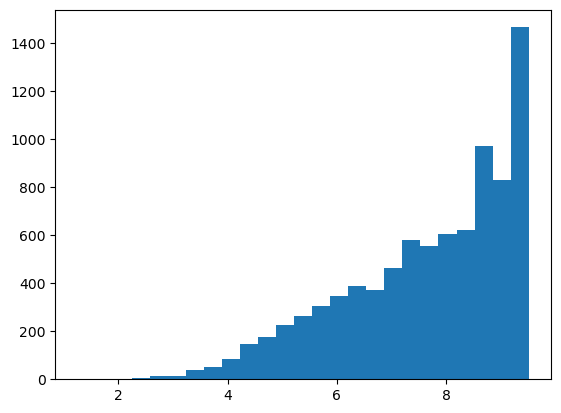

In [34]:
# histogram of idf, where idf isn't max(idf)
import matplotlib.pyplot as plt
plt.hist(idf[idf['idf'] != max(idf['idf'])]['idf'], bins=25)
plt.show()

In [38]:
import tqdm

# go through the pip vocabulary and find the idf of each topic
conn.rollback()
for i in tqdm.tqdm(pipe['count'].vocabulary_, total=len(pipe['count'].vocabulary_)):
    cur.execute("UPDATE topics SET idf = %s WHERE topics_preprocessed = %s", (pipe['tfid'].idf_[pipe['count'].vocabulary_[i]], i))
    conn.commit()

100%|████████████████████████████████████| 59521/59521 [06:40<00:00, 148.49it/s]
